In [244]:
import torch
from opacus_new.accountants.utils import get_noise_multiplier

# Example dataset size
n = 5000  # number of samples

# Two distinct batch sizes
batch_size_1 = 500
batch_size_2 = 4000

# Number of epochs
x_1 = 1
x_2 = 10

# Target DP parameters
epsilon = 2
delta = 0.08

# Compute sample rates
sample_rate_1 = batch_size_1 / n
sample_rate_2 = batch_size_2 / n

print(f"Sample rate for batch size {batch_size_1}: {sample_rate_1:.4f}")
print(f"Sample rate for batch size {batch_size_2}: {sample_rate_2:.4f}")

# Compute noise multipliers using RDP accountant
noise_multiplier_1 = get_noise_multiplier(
    sample_rate=sample_rate_1,
    steps=x_1 * (n // batch_size_1),
    target_epsilon=epsilon,
    target_delta=delta,
)

noise_multiplier_2 = get_noise_multiplier(
    sample_rate=sample_rate_2,
    steps=x_2 * (n // batch_size_2),
    target_epsilon=epsilon,
    target_delta=delta,
)

print(f"Noise multiplier for batch size {batch_size_1}: {noise_multiplier_1:.4f}")
print(f"Noise multiplier for batch size {batch_size_2}: {noise_multiplier_2:.4f}")


Sample rate for batch size 500: 0.1000
Sample rate for batch size 4000: 0.8000
Noise multiplier for batch size 500: 0.6543
Noise multiplier for batch size 4000: 2.4072


In [245]:
from opacus_new.accountants import RDPAccountant

def compute_epsilon_delta(noise_multiplier, deltas, iterations, sampling_rate, clipping_norm):
    accountant = RDPAccountant()
    for _ in range(int(iterations)):
        accountant.step(noise_multiplier=noise_multiplier * 1/clipping_norm, sample_rate=sampling_rate)
    epsilons = []
    deltas2 = []
    for delta in deltas:
        epsilon = accountant.get_epsilon(delta)
        epsilons.append(epsilon)
        deltas2.append(delta)
    return epsilons, deltas2

In [246]:
import numpy as np
deltas = np.logspace(-10, 0, num=300, endpoint=False)
# deltas = np.linspace(1e-10, 1-1e-10, num=100, endpoint=False)
eps1, deltas1 = compute_epsilon_delta(noise_multiplier_1, deltas, x_1 * (n // batch_size_1), sample_rate_1, 1)
eps2, deltas2 = compute_epsilon_delta(noise_multiplier_2, deltas, x_2 * (n // batch_size_2), sample_rate_2, 1)

/tmp/ipykernel_2213878/1632516087.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


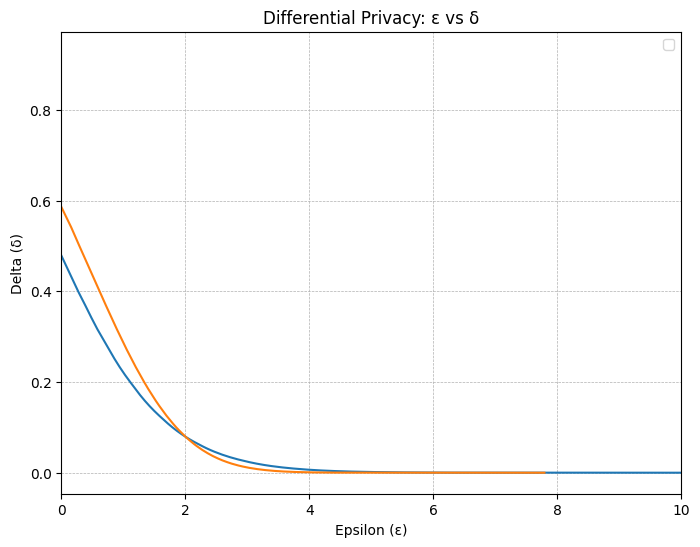

In [247]:
import matplotlib.pyplot as plt
# Create plot
plt.figure(figsize=(8, 6))
plt.plot(eps1, deltas1)
plt.plot(eps2, deltas2)

# plt.yscale('log')  # DP deltas are usually plotted on a log scale
plt.xlabel('Epsilon (ε)')
plt.xlim(0, 10)
plt.ylabel('Delta (δ)')
plt.title('Differential Privacy: ε vs δ')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

In [248]:
def f_eps_delta(alpha, epsilon, delta):
    """Piecewise linear trade-off function f_{ε, δ} (from pure (ε, δ)-DP)."""
    return np.maximum(
        0,
        np.maximum(
            1 - delta - np.exp(epsilon) * alpha,
            np.exp(-epsilon) * (1 - delta - alpha),
        ),
    )

/tmp/ipykernel_2213878/2635250882.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blue_cmap = cm.get_cmap("Blues", max(len(max(epsilon_sets, key=len)), 2))


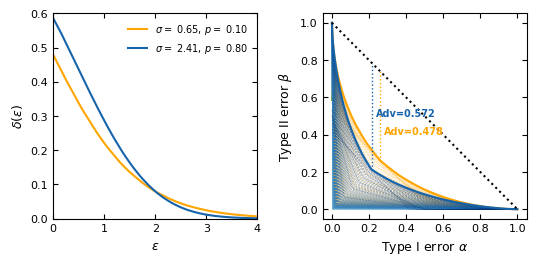

In [258]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

epsilon_sets = [eps1, eps2]
delta_sets = [deltas1, deltas2]
alpha_grid = np.linspace(0, 1, 200)

# --------------------
# Figure setup: slim, wide, paper-style
# --------------------
fig, axes = plt.subplots(1, 2, figsize=(5.25, 2.5))  # width for paper column, slim height
ax_left, ax_right = axes

plt.rcParams.update({
    "font.size": 8,       # smaller font for paper
    "axes.labelsize": 9,
    "axes.titlesize": 9,
    "legend.fontsize": 7,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
})

# --------------------
# Define colors for each group
# --------------------
group_colors = ['orange', cm.Blues(0.8)]

# --------------------
# Left subplot: ε vs δ
# --------------------
ax_left.plot(
    epsilon_sets[0], delta_sets[0],
    color=group_colors[0],
    label=rf'$\sigma =$ {noise_multiplier_1:.2f}, $p = $ {sample_rate_1:.2f}'
)
ax_left.plot(
    epsilon_sets[1], delta_sets[1],
    color=group_colors[1],
    label=rf'$\sigma =$ {noise_multiplier_2:.2f}, $p = $ {sample_rate_2:.2f}'
)
ax_left.set_xlabel(r'$\varepsilon$')
ax_left.set_ylabel(r'$\delta(\varepsilon)$')
ax_left.set_xlim(0, 4)
ax_left.set_ylim(0, 0.6)
ax_left.legend(frameon=False, loc="upper right")

# --------------------
# Right subplot: Trade-off curves
# --------------------
n_groups = len(epsilon_sets)
blue_cmap = cm.get_cmap("Blues", max(len(max(epsilon_sets, key=len)), 2))

for i, (epsilons, deltas) in enumerate(zip(epsilon_sets, delta_sets)):
    f_values = np.array([f_eps_delta(alpha_grid, eps, delta) for eps, delta in zip(epsilons, deltas)])
    envelope = np.max(f_values, axis=0)
    
    curve_color = group_colors[i]
    
    for idx, f_val in enumerate(f_values):
        color_plot = curve_color if i == 0 else blue_cmap(idx / max(len(f_values)-1, 1))
        ax_right.plot(alpha_grid, f_val, color=color_plot, alpha=0.4, linewidth=0.4, linestyle="--")
    
    # Envelope in group color
    ax_right.plot(alpha_grid, envelope, color=curve_color, linewidth=1.5, label=f'Envelope {i+1}')
    
    # Advantage
    trivial = 1 - alpha_grid
    diff = trivial - envelope
    max_idx = np.argmax(np.nan_to_num(diff))
    advantage = diff[max_idx]
    
    adv_color = curve_color
    ax_right.plot([alpha_grid[max_idx], alpha_grid[max_idx]],
                  [envelope[max_idx], trivial[max_idx]],
                  color=adv_color, linestyle=':', linewidth=1)
    
    v_offset = -0.1 if i == 0 else 0.0
    ax_right.text(alpha_grid[max_idx] + 0.02,
                  envelope[max_idx] + advantage/2 + v_offset,
                  f"Adv={advantage:.3f}",
                  color=adv_color,
                  fontsize=7,
                  fontweight='bold')

ax_right.plot([0, 1], [1, 0], 'k:', label='y=1-x')
ax_right.set_xlabel(r"Type I error $\alpha$")
ax_right.set_ylabel(r"Type II error $\beta$")

# --------------------
# Layout for paper
# --------------------
for ax in [ax_left, ax_right]:
    ax.tick_params(direction="in", top=True, right=True)  # ticks inside
    # ax.label_outer()  # reduce redundant labels in tight layout

plt.tight_layout(pad=0.2, w_pad=1.5)  # very slim margins
plt.savefig("/vol/miltank/users/kaiserj/Clipping_vs_Sampling/extra_figs/teaser.png", dpi=300)
plt.savefig("/vol/miltank/users/kaiserj/Clipping_vs_Sampling/extra_figs/teaser.svg", dpi=300)
plt.show()

